In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# CNN Example

In [10]:


transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root="../Pre-processing/Curated_Dataset", transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
num_classes = len(dataset.classes)

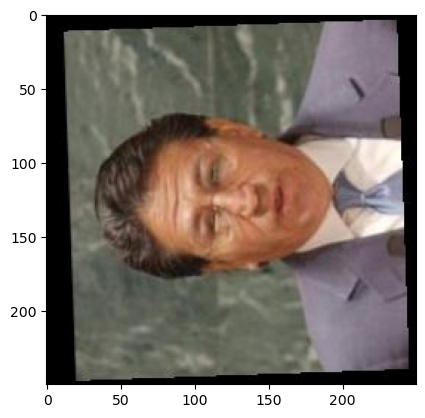

In [11]:
plt.imshow(dataset[0][0].T)

In [12]:
# images are (250, 250, 3)
# (((W - K + 2P)/S) + 1)
#         Here W = Input size
#         K = Filter size
#         S = Stride
#         P = Padding 

import torchvision.models as models

vgg16 = models.vgg16(pretrained=False)
vgg16.classifier[6] = nn.Linear(4096, num_classes)
vgg16 = vgg16.to(device)

criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(vgg16.parameters(), lr=0.0001) 


c:\Users\danie\anaconda3\envs\FaceTorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\danie\anaconda3\envs\FaceTorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [13]:
num_epochs = 0

for epoch in range(num_epochs):
    vgg16.train()  # Set the model to training mode
    
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        
        outputs = vgg16(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        
        loss.backward()  # Backward pass (calculate gradients)
        optimizer.step()  # Update weights
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    
    # Validate the model
    vgg16.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = vgg16(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader.dataset)
    accuracy = correct / total
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
data = pd.read_csv('../Pre-processing/dataset/anchor_points_dataset/data_points.csv')


X = data.drop(columns=['label']).to_numpy()
y = data['label'].to_numpy()

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

input_size = X_train.shape[1]
num_classes = len(label_encoder.classes_)
data['label'].value_counts()

label
Tony_Blair               258
Hugo_Chavez              111
Junichiro_Koizumi        108
Jean_Chretien            102
Jacques_Chirac            96
                        ... 
Mohammad_Khatami          14
Taha_Yassin_Ramadan       12
Kim_Ryong-sung            12
Nicanor_Duarte_Frutos     11
John_Allen_Muhammad        8
Name: count, Length: 119, dtype: int64

#### MetricNet 

In [15]:
from metricNet import MetricNet

model = MetricNet(input_size=input_size, num_classes=(True,num_classes))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 1
batch_size = 500
 
for epoch in range(n_epochs):
    model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        Xbatch = X_train_tensor[i:i+batch_size]
        ybatch = y_train_tensor[i:i+batch_size]

        y_pred = model(Xbatch)
        loss = criterion(y_pred, ybatch)
        print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        _, val_pred = torch.max(val_outputs, 1)
        val_accuracy = accuracy_score(y_test_tensor.numpy(), val_pred.numpy())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}, Val Accuracy: {val_accuracy * 100:.2f}%")


tensor(4.8183, grad_fn=<NllLossBackward0>)
tensor(4.8514, grad_fn=<NllLossBackward0>)
tensor(4.8138, grad_fn=<NllLossBackward0>)
tensor(4.8044, grad_fn=<NllLossBackward0>)
tensor(4.8094, grad_fn=<NllLossBackward0>)
tensor(4.8080, grad_fn=<NllLossBackward0>)
tensor(4.8196, grad_fn=<NllLossBackward0>)
tensor(4.7686, grad_fn=<NllLossBackward0>)


## Face Validation

In [ ]:
from bioNet import BioNet, BioNetLoss
from torchvision.datasets import LFWPairs
from sklearn.metrics import accuracy_score

mu_m = torch.tensor([0]).to(device) # Matching
mu_n = torch.tensor([40]).to(device) # Non-matching

sigma = torch.tensor([[1.0]]).to(device)
p = torch.tensor([1]).to(device)

batch_size = 100
learning_rate = 1e-3

model = BioNet().to(device=device)
criterion = BioNetLoss(p, mu_n, mu_m, sigma)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize images to 299x299
    transforms.ToTensor()])

lfw_pairs_dataset_train = LFWPairs(
    root="./data/train",  
    split="train",  
    transform=transform,
    download=True
)
lfw_pairs_dataset_test = LFWPairs(
    root="./data/test",  
    split="test",  
    transform=transform,
    download=True
)

train_loader = DataLoader(lfw_pairs_dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(lfw_pairs_dataset_test, batch_size=batch_size, shuffle=True)

epochs = 100


for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    

    for img1, img2, labels in train_loader:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

        
        # Forward pass
        distances = model(img1, img2, img1.shape[0] )
        # Compute loss
        loss = criterion(distances, labels.float())
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    all_predictions = []
    all_labels = []
    all_distance = []
    model.eval()  # Switch to evaluation mode
    with torch.no_grad():
        for img1, img2, labels in test_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            
            distances = model(img1, img2, img1.shape[0])
            
            predictions = (distances < criterion.threshold()).float()
            all_distance.extend(distances.detach().cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute accuracy
    all_distance =  [float(x) for sublist in all_distance for x in sublist]
    all_predictions = [int(x) for sublist in all_predictions for x in sublist]


    accuracy = accuracy_score(all_labels, all_predictions)

    print(all_distance[:10])
    print(all_predictions[:10])
    print(all_labels[:10])
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}, Accuracy: {accuracy:.4f}")

Files already downloaded and verified
Files already downloaded and verified
